In [94]:
# data, system tools
import pandas as pd
import numpy as np
import os
import glob
import itertools

# multiprocessing
import multiprocessing as mp
from functools import partial

# stats
from statsmodels.stats import outliers_influence
import statsmodels.stats.multitest as multi
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statannot
import scipy
import scipy.stats

# plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [95]:
row_order = ['AMG', 'CL', 'fx', 'GPe', 'GPi', 'ic', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'STR', 'THA', 'VTA', 'LV', '3V', '4V']
multi_tuples = [('iron', 'median'), ('myelin', 'median'), ('iron', 'iqr'), ('myelin', 'iqr'), ('volume', 'volume'), ('thickness', 'median'), ('thickness', 'iqr')]
multi_cols = pd.MultiIndex.from_tuples(multi_tuples, names=['metric', 'Statistic'])

# Load data
final_table_proportional_f = pd.read_pickle('../data/interim_data/summary_table_qmri_proportional_f.pkl')
final_table_proportional_f = final_table_proportional_f.reindex(row_order)
final_table_proportional_f = final_table_proportional_f[multi_cols]
final_table_proportional_f['sex'] = 'f'
final_table_proportional_f = final_table_proportional_f.reset_index().set_index(['sex', 'ROI'])

final_table_proportional_m = pd.read_pickle('../data/interim_data/summary_table_qmri_proportional_m.pkl')
final_table_proportional_m = final_table_proportional_m.reindex(row_order)
final_table_proportional_m = final_table_proportional_m[multi_cols]
# final_table_proportional_m = final_table_proportional_m.iloc[:,[1,0,3,2,5,4]]
# final_table_proportional_m = final_table_proportional_m.iloc[[0,1,4,5,6,7,9,10,11,12,13,14,15,8,16,17,18],:] # remove cortex cerebellum, move ventricles together
final_table_proportional_m['sex'] = 'm'
final_table_proportional_m = final_table_proportional_m.reset_index().set_index(['sex', 'ROI'])

final_table_proportional = pd.concat([final_table_proportional_f, final_table_proportional_m])
final_table_proportional_melted = final_table_proportional.melt()
final_table_proportional.columns = ['_'.join(x) for x in final_table_proportional.columns]

# Get correspoding mean residual errors
msers = pd.read_pickle('../data/interim_data/summary_table_qmri_rescaled_msres.pkl')
msers = msers.reindex(row_order)
msers = msers[multi_cols]
# msers = msers.iloc[:,[1,0,3,2,5,4]]
# msers = msers.iloc[[0,1,4,5,6,7,9,10,11,12,13,14,15,8,16,17,18],:] # remove cortex cerebellum, move ventricles together
msers = msers.reset_index().set_index('ROI')
msers.columns = ['_'.join(x) for x in msers.columns]

# # load model
# models = pd.read_pickle('./app/app/data/winning_models/qmri_age_models.pkl')
# models.head()

In [86]:
bootstrapped_CI = pd.read_pickle('../data/bootstraps/all_bootstrapped_data_n=1000.pkl')
bootstrapped_CI

,ROI,qMRI,Statistic,ivs,model,result,BIC,rsquared,is_winner_BIC,ivs_2,new_winning_model_3,bootstrap_results
9,3V,iron,median,Age2 + sex,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,323.605685,2.049183e-01,True,Age2 + sex,False,{'absolute_mean_change': {'CI': [-1.7375938659...
30,3V,iron,iqr,Age2,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,522.990511,2.993918e-01,True,Age2,False,{'absolute_mean_change': {'CI': [-6.9787482483...
48,3V,myelin,median,1,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,330.545791,2.220446e-16,True,1,False,"{'absolute_mean_change': {'CI': [0.0, 0.0], 'S..."
80,3V,myelin,iqr,Age2 + Age:sex,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,194.409033,1.389058e-01,True,Age2 + Age:sex,False,{'absolute_mean_change': {'CI': [-0.8985085089...
96,3V,r1hz,median,1,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,-346.215862,-2.220446e-16,True,1,False,"{'absolute_mean_change': {'CI': [0.0, 0.0], 'S..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6420,ic,qpd,iqr,Age,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,-531.336550,1.862399e-01,True,Age,False,{'absolute_mean_change': {'CI': [0.01464266881...
6432,ic,thickness,median,1,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,35.655007,0.000000e+00,True,1,False,"{'absolute_mean_change': {'CI': [0.0, 0.0], 'S..."
6456,ic,thickness,iqr,1,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,-41.971046,1.110223e-16,True,1,False,"{'absolute_mean_change': {'CI': [0.0, 0.0], 'S..."
6482,ic,volume,voxels,Age:sex,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,1821.707820,1.138773e-01,True,Age:sex,False,{'absolute_mean_change': {'CI': [254.123852081...


In [59]:
bootstrapped_CI = pd.read_pickle('../data/bootstraps/all_bootstrapped_data_n=1000.pkl')
bootstrapped_CI['CI_lower_f'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['CI'][0])
bootstrapped_CI['CI_upper_f'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['CI'][1])
bootstrapped_CI['CI_lower_m'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_m']['CI'][0])
bootstrapped_CI['CI_upper_m'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_m']['CI'][1])
bootstrapped_CI['median_f'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['median'])
bootstrapped_CI['median_m'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['median'])
bootstrapped_CI['SE_f'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['SE'])
bootstrapped_CI['SE_m'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['SE'])

In [36]:
bootstrapped_CI_combined = bootstrapped_CI.pivot_table(values=['median_f', 'median_m', 'SE_f', 'SE_m', 'CI_lower_f', 'CI_lower_m', 'CI_upper_f', 'CI_upper_m'], index='ROI', columns=['qMRI', 'Statistic']).T.reset_index()#.reindex(row_order)[multi_cols]
bootstrapped_CI_combined = bootstrapped_CI_combined.rename(columns = {'level_0': 'depvar'})
bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'].apply(lambda x: x.endswith('_f')), 'sex'] = 'f'
bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'].apply(lambda x: x.endswith('_m')), 'sex'] = 'm'
bootstrapped_CI_combined['depvar'] = bootstrapped_CI_combined['depvar'].apply(lambda x: x[:-2])
bootstrapped_CI_combined = bootstrapped_CI_combined.melt(id_vars=['depvar', 'sex', 'qMRI', 'Statistic'])

bootstrapped_SE = bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'] == 'SE'].pivot_table(columns=['qMRI', 'Statistic'], index=['ROI', 'sex'])
bootstrapped_CI_lower = bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'] == 'CI_lower'].pivot_table(columns=['qMRI', 'Statistic'], index=['ROI', 'sex'])
bootstrapped_CI_upper = bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'] == 'CI_upper'].pivot_table(columns=['qMRI', 'Statistic'], index=['ROI', 'sex'])
bootstrapped_median = bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'] == 'median'].pivot_table(columns=['qMRI', 'Statistic'], index=['ROI', 'sex'])

In [37]:
bootstrapped_CI_combined = bootstrapped_CI.pivot_table(values=['median_f', 'median_m', 'SE_f', 'SE_m', 'CI_lower_f', 'CI_lower_m', 'CI_upper_f', 'CI_upper_m'], index='ROI', columns=['qMRI', 'Statistic']).T.reset_index()#.reindex(row_order)[multi_cols]
bootstrapped_CI_combined = bootstrapped_CI_combined.rename(columns = {'level_0': 'depvar'})
bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'].apply(lambda x: x.endswith('_f')), 'sex'] = 'f'
bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'].apply(lambda x: x.endswith('_m')), 'sex'] = 'm'
bootstrapped_CI_combined['depvar'] = bootstrapped_CI_combined['depvar'].apply(lambda x: x[:-2])
bootstrapped_CI_combined = bootstrapped_CI_combined.melt(id_vars=['depvar', 'sex', 'qMRI', 'Statistic'])

bootstrapped_SE = bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'] == 'SE'].pivot_table(columns=['qMRI', 'Statistic'], index=['ROI', 'sex'])
bootstrapped_CI_lower = bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'] == 'CI_lower'].pivot_table(columns=['qMRI', 'Statistic'], index=['ROI', 'sex'])
bootstrapped_CI_upper = bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'] == 'CI_upper'].pivot_table(columns=['qMRI', 'Statistic'], index=['ROI', 'sex'])
bootstrapped_median = bootstrapped_CI_combined.loc[bootstrapped_CI_combined['depvar'] == 'median'].pivot_table(columns=['qMRI', 'Statistic'], index=['ROI', 'sex'])

bootstrapped_SE.columns = bootstrapped_SE.columns.droplevel()
bootstrapped_CI_lower.columns = bootstrapped_CI_lower.columns.droplevel()
bootstrapped_CI_upper.columns = bootstrapped_CI_upper.columns.droplevel()
bootstrapped_median.columns = bootstrapped_median.columns.droplevel()

bootstrapped_SE = bootstrapped_SE[multi_cols]
bootstrapped_median = bootstrapped_median[multi_cols]
bootstrapped_CI_upper = bootstrapped_CI_upper[multi_cols]
bootstrapped_CI_lower = bootstrapped_CI_lower[multi_cols]

bootstrapped_SE.columns = ['_'.join(x) for x in bootstrapped_SE.columns]
bootstrapped_CI_lower.columns = ['_'.join(x) for x in bootstrapped_CI_lower.columns]
bootstrapped_CI_upper.columns = ['_'.join(x) for x in bootstrapped_CI_upper.columns]
bootstrapped_median.columns = ['_'.join(x) for x in bootstrapped_median.columns]

### Which regions change most?

In [38]:
## Set ventricle values of iron/myelin to 0
for dv in ['iron_median', 'iron_iqr', 'myelin_median', 'myelin_iqr']:
    for sex in ['m', 'f']:
        for roi in ['LV', '3V', '4V']:
            final_table_proportional.loc[(sex, roi), dv] = 0
            bootstrapped_CI_upper.loc[(roi, sex), dv] = 0
            bootstrapped_CI_lower.loc[(roi, sex), dv] = 0
            bootstrapped_median.loc[(roi, sex), dv] = 0
            bootstrapped_SE.loc[(roi, sex), dv] = 0
            msers.loc[roi, dv] = 0

#final_table_proportional = final_table_proportional.abs()
final_table_proportional['total'] = final_table_proportional.sum(1)
final_table_proportional = final_table_proportional.reset_index().set_index('ROI')
final_table_proportional['total_ROI'] = final_table_proportional.reset_index().groupby(['ROI'])['total'].mean()
final_table_proportional = final_table_proportional.reset_index().set_index(['ROI', 'sex']).sort_values(['total_ROI', 'sex'], ascending=False)

final_table_proportional.head()

# get same order
msers = msers.loc[final_table_proportional.reset_index().ROI.values]
msers.head()

bootstrapped_SE = bootstrapped_SE.loc[final_table_proportional.index]
bootstrapped_CI_upper = bootstrapped_CI_upper.loc[final_table_proportional.index]
bootstrapped_CI_lower = bootstrapped_CI_lower.loc[final_table_proportional.index]
bootstrapped_median = bootstrapped_median.loc[final_table_proportional.index]

### Manually create stacked bar plot

In [39]:
# index for plotting
final_table_proportional['index'] = np.repeat(np.arange(final_table_proportional.shape[0]/2), 2)

## Final figure

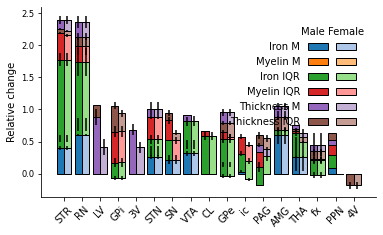

In [40]:
## SEs instead of MSER
width = 0.4
widths = np.repeat(width, final_table_proportional.shape[0])
widths *= np.tile([-1,1], int(final_table_proportional.shape[0]/2))
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

f, ax = plt.subplots(1,1, figsize=(6,3.5))
ax = [ax]

is_plotted = []
for i, dv in enumerate(['iron_median', 'myelin_median', 'iron_iqr', 'myelin_iqr', 'thickness_median', 'thickness_iqr']):
#     errbar = msers[dv]
    errbar = bootstrapped_SE[dv]
    if i == 0:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv, 
                  yerr=errbar)
    else:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv,
                  yerr=errbar,
                  bottom=final_table_proportional[is_plotted].sum(1))
        
    is_plotted.append(dv)

ax[0].set_xticks(ticks = np.arange(17))
ax[0].set_xticklabels(final_table_proportional.index.get_level_values(0).unique(), rotation=45, ha='center')
ax[0].set_ylabel('Relative change')

# custom legend
lwd = 1
custom_lines = [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(0,11,2)] + \
               [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(1,13,2)]

#
leg = ax[0].legend(custom_lines, ['Male', 'Iron M', 'Myelin M', 'Iron IQR', 'Myelin IQR', 'Thickness M', 'Thickness IQR',
                                  'Female', '', '' ,'' ,'' ,'', '', ''], ncol=2, markerfirst=False, 
                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False)
for i, vpack in enumerate(leg._legend_handle_box.get_children()):
    for j, hpack in enumerate(vpack.get_children()[:1]):
        if i == 0:
            hpack.get_children()[1].set_width(-5)
        else:
            hpack.get_children()[1].set_width(-16)

sns.despine()
# f.savefig('../figures/figure4-v5.pdf', bbox_inches='tight')

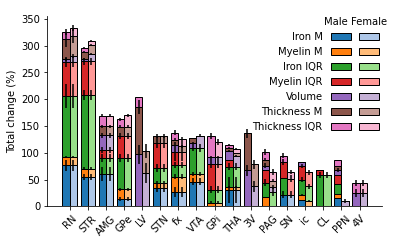

In [7]:
## SEs instead of MSER
width = 0.4
widths = np.repeat(width, final_table_proportional.shape[0])
widths *= np.tile([-1,1], int(final_table_proportional.shape[0]/2))
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

f, ax = plt.subplots(1,1, figsize=(6,3.5))
ax = [ax]

is_plotted = []
for i, dv in enumerate(['iron_median', 'myelin_median', 'iron_iqr', 'myelin_iqr', 'volume_volume', 'thickness_median', 'thickness_iqr']):
#     errbar = msers[dv]
    errbar = bootstrapped_SE[dv]
    if i == 0:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv, 
                  yerr=errbar)
    else:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv,
                  yerr=errbar,
                  bottom=final_table_proportional[is_plotted].sum(1))
    is_plotted.append(dv)

ax[0].set_xticks(ticks = np.arange(17))
ax[0].set_xticklabels(final_table_proportional.index.get_level_values(0).unique(), rotation=45, ha='center')
ax[0].set_ylabel('Total change (%)')
ax[0].set_yticks(np.arange(0,4,.5))
ax[0].set_yticklabels((np.arange(0,4,.5)*100).astype(int))

# custom legend 
lwd = 1
custom_lines = [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(0,13,2)] + \
               [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(1,15,2)]

#
leg = ax[0].legend(custom_lines, ['Male', 'Iron M', 'Myelin M', 'Iron IQR', 'Myelin IQR', 'Volume', 'Thickness M', 'Thickness IQR',
                                  'Female', '', '' ,'' ,'' ,'', '', '', ''], ncol=2, markerfirst=False, 
                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False,
                   bbox_to_anchor=(.55, .6, 0.5, 0.5))
for i, vpack in enumerate(leg._legend_handle_box.get_children()):
    for j, hpack in enumerate(vpack.get_children()[:1]):
        if i == 0:
            hpack.get_children()[1].set_width(-5)
        else:
            hpack.get_children()[1].set_width(-16)

sns.despine()
# print([x.get_text() for x in ax[0].get_yticklabels()])
f.savefig('../figures/figure4-v6-massp2.pdf', bbox_inches='tight')

### No grouping

In [8]:
# indx = final_table_proportional['iron_median'].groupby(level=0).mean().sort_values(ascending=False).index
# errbars = bootstrapped_SE.loc[indx]['iron_median']
# medians = final_table_proportional.loc[indx]['iron_median']

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


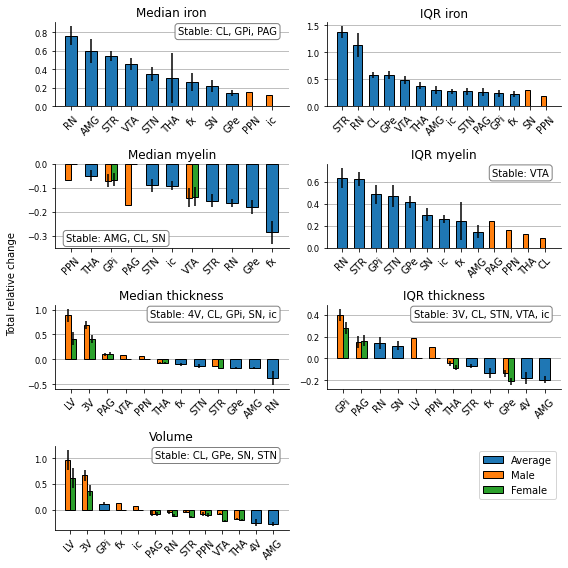

In [41]:
#width = 0.4
#widths = np.repeat(width, final_table_proportional.shape[0])
#widths *= np.tile([-1,1], int(final_table_proportional.shape[0]/2))
widths = [0.6, 0.3]
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

f, ax = plt.subplots(4,2, figsize=(8,8))

is_plotted = []
for i, measure in enumerate(['iron', 'myelin', 'thickness', 'volume']):
    for ii, statistic in enumerate(['median', 'iqr']):
#        dv_colname = measure
        if measure == 'volume':
            statistic = 'volume'
        dv_colname = measure+'_'+statistic
        
        if measure == 'volume' and ii == 1:
            continue
        ax[i,ii].grid(which='both', axis='y')
        ax[i,ii].set_axisbelow(True)
        
        tmp = final_table_proportional[dv_colname]
        indx = tmp.groupby(level=0).mean().sort_values(ascending=False).index  # sorting
        if measure in ['iron', 'myelin']:
            indx = np.array([x for x in indx if not x in ['LV', '3V', '4V']])  # don't plot ventricles here
        tmp = tmp.loc[indx]  # remove ventricles if necessary
        
        rois_without_change = tmp.groupby(level=0).mean()==0
        tmp = tmp.loc[rois_without_change[~rois_without_change].index]  # remove rois that are stable
        rois_without_change = rois_without_change[rois_without_change].index
        indx = np.array([x for x in indx if not x in rois_without_change])      # remove rois that are stable
        
        errbars = bootstrapped_SE.reindex(indx, level=0)[dv_colname]
        medians = final_table_proportional.reindex(indx, level=0)[dv_colname]
        widths_ = widths[:indx.shape[0]*2]
        x = np.repeat(np.arange(indx.shape[0]), 2)
        
        # loop
        positions = []
        pos = -0.2 - widths[0]
        for iii, roi in enumerate(indx):
            values = final_table_proportional.loc[roi, dv_colname]
            if values.unique().shape[0] == 1:  # m and f are the same
#                pos += 0.2 + widths[0]
                ax[i,ii].bar(x=iii, 
                             height=values[0], 
                             yerr=bootstrapped_SE.loc[roi, dv_colname][0],
                             color=cmap(norm(0)), edgecolor='k', width=widths[0])
            else:
#                pos += 0.2 + widths[1]
                ax[i,ii].bar(x=iii + np.array([-.5*widths[1], .5*widths[1]]), #pos + np.array([-.5*widths[1], .5*widths[1]]), 
                             height=values, 
                             yerr=bootstrapped_SE.loc[roi, dv_colname],
                             color=[cmap(norm(2)), cmap(norm(4))], edgecolor='k', width=widths[1])
        
#             positions.append(pos)

        ax[i,ii].set_xticks(ticks = np.arange(len(x)/2))
        ax[i,ii].set_xticklabels(indx, rotation=45, ha='center')
        if measure == 'myelin' and statistic == 'median':
            xy_loc = (0.05, 0.05)
            va='bottom'
            ha='left'
        else:
            xy_loc = (0.95, 0.95)
            va='top'
            ha='right'
        if not (measure == 'iron' and statistic == 'iqr'):
            ax[i,ii].annotate(s='Stable: {}'.format(', '.join(rois_without_change)), 
                              xy=xy_loc, xycoords='axes fraction',
                              ha=ha, va=va,bbox=dict(boxstyle="round", fc="w", edgecolor='gray'))
#        ax[i,ii].text(0,0,s='Stable: {}'.format(', '.join(rois_without_change)))
#        ax[i,ii].set_ylabel(dv_colname)

    is_plotted.append(dv)

custom_lines = [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=1, ec='k') for x in [0,2,4]]

#
leg = ax[-1,-1].legend(custom_lines, ['Average', 'Male', 'Female']) #, ncol=1, markerfirst=False, 
#                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False,
#                   bbox_to_anchor=(.55, .6, 0.5, 0.5))

ax[0,0].set_title('Median iron')
ax[0,1].set_title('IQR iron')
ax[1,0].set_title('Median myelin')
ax[1,1].set_title('IQR myelin')
ax[2,0].set_title('Median thickness')
ax[2,1].set_title('IQR thickness')
ax[3,0].set_title('Volume')

ax[-1,-1].axis('off')
f.supylabel('Total relative change')
f.tight_layout()

sns.despine()
# f.savefig('./figure6newtest.pdf', bbox_inches='tight')

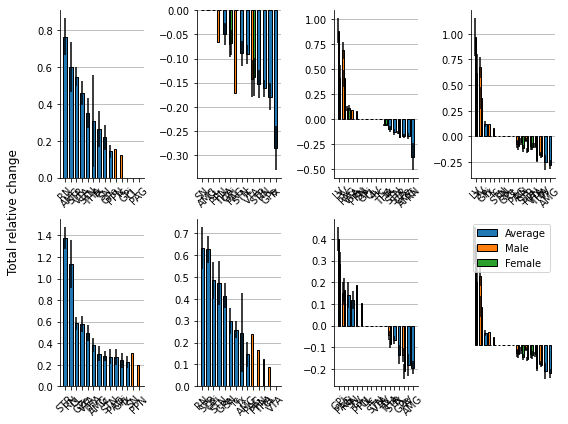

In [20]:
#width = 0.4
#widths = np.repeat(width, final_table_proportional.shape[0])
#widths *= np.tile([-1,1], int(final_table_proportional.shape[0]/2))
widths = [0.6, 0.3]
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

f, ax = plt.subplots(2,4, figsize=(8,6))

is_plotted = []
for ii, measure in enumerate(['iron', 'myelin', 'thickness', 'volume']):
    for i, statistic in enumerate(['median', 'iqr']):
#        dv_colname = measure
        if measure == 'volume':
            statistic = 'volume'
        dv_colname = measure+'_'+statistic
        
        if measure == 'volume' and ii == 1:
            continue
        ax[i,ii].grid(which='both', axis='y')
        ax[i,ii].set_axisbelow(True)
        
        indx = final_table_proportional[dv_colname].groupby(level=0).mean().sort_values(ascending=False).index
        if measure in ['iron', 'myelin']:
            indx = np.array([x for x in indx if not x in ['LV', '3V', '4V']])  # don't plot ventricles here
        errbars = bootstrapped_SE.reindex(indx, level=0)[dv_colname]
        medians = final_table_proportional.reindex(indx, level=0)[dv_colname]
        widths_ = widths[:indx.shape[0]*2]
        x = np.repeat(np.arange(indx.shape[0]), 2)
        
        # loop
        positions = []
        pos = -0.2 - widths[0]
        for iii, roi in enumerate(indx):
            values = final_table_proportional.loc[roi, dv_colname]
            if values.unique().shape[0] == 1:  # m and f are the same
#                pos += 0.2 + widths[0]
                ax[i,ii].bar(x=iii, 
                             height=values[0], 
                             yerr=bootstrapped_SE.loc[roi, dv_colname][0],
                             color=cmap(norm(0)), edgecolor='k', width=widths[0])
            else:
#                pos += 0.2 + widths[1]
                ax[i,ii].bar(x=iii + np.array([-.5*widths[1], .5*widths[1]]), #pos + np.array([-.5*widths[1], .5*widths[1]]), 
                             height=values, 
                             yerr=bootstrapped_SE.loc[roi, dv_colname],
                             color=[cmap(norm(2)), cmap(norm(4))], edgecolor='k', width=widths[1])
        
#             positions.append(pos)

        ax[i,ii].set_xticks(ticks = np.arange(len(x)/2))
        ax[i,ii].set_xticklabels(indx, rotation=45, ha='center')
#        ax[i,ii].set_ylabel(dv_colname)

    is_plotted.append(dv)

custom_lines = [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=1, ec='k') for x in [0,2,4]]

#
leg = ax[-1,-1].legend(custom_lines, ['Average', 'Male', 'Female']) #, ncol=1, markerfirst=False, 
#                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False,
#                   bbox_to_anchor=(.55, .6, 0.5, 0.5))

# ax[0,0].set_title('Median iron')
# ax[0,1].set_title('IQR iron')
# ax[1,0].set_title('Median myelin')
# ax[1,1].set_title('IQR myelin')
# ax[2,0].set_title('Median thickness')
# ax[2,1].set_title('IQR thickness')
# ax[3,0].set_title('Volume')

ax[-1,-1].axis('off')
f.supylabel('Total relative change')
f.tight_layout()

sns.despine()
f.savefig('./figure6newtest2.pdf', bbox_inches='tight')

### maybe try 3 rows, and 2,2,3 columns?

KeyError: 'RN'

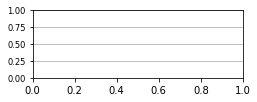

In [69]:
import matplotlib.gridspec as gridspec
rcPars_to_update = {'figure.titlesize': 'medium',
                    'font.size': 10,
                    'ytick.labelsize': 'small',
                    'ytick.labelsize': 'small',
                    }
matplotlib.rcParams.update(**rcPars_to_update)

widths = [0.6, 0.4]
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

#f, ax = plt.subplots(4,2, figsize=(8,8))
f = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(nrows=3, ncols=6, figure=f, height_ratios=(2,2,4), hspace=.3, wspace=.5)
#gs0 = gridspec.GridSpecFromSubplotSpec(2,2,gs[0,0], width_ratios=[3,4])  #myelin,iron
#gs1 = gridspec.GridSpecFromSubplotSpec(1,3,gs[1,0])  #thickness, volume

all_axes = []
for i, measure in enumerate(['iron', 'myelin', 'thickness', 'volume']):
    for ii, statistic in enumerate(['median', 'iqr']):
        if measure == 'volume':
            statistic = 'volume'
        dv_colname = measure+'_'+statistic
        if measure == 'volume' and ii == 1:
            continue
        
        ##
        if measure in ['iron', 'myelin']:
            col = slice(0,3) if statistic == 'median' else slice(3,6)
        else:
            col = slice(0,2) if statistic == 'median' else slice(2,4) if statistic == 'iqr' else slice(4,6)
        i = np.min([i,2])
#         col = slice(ii*2, ii*2+2) if measure in ['thickness', 'volume'] else slice(0,3) if measure == 'iron' else slice(3,6)
        
        this_ax = f.add_subplot(gs[i,col])
        this_ax.grid(which='both', axis='y')
        this_ax.set_axisbelow(True)
        
        tmp = final_table_proportional[dv_colname]
        indx = tmp.groupby(level=1).mean().sort_values(ascending=(measure == 'myelin' and statistic == 'median')).index  # sorting # tmp.groupby(level=0).mean().sort_values(ascending=(measure == 'myelin' and statistic == 'median')).index  # sorting
        if measure in ['iron', 'myelin']:
            indx = np.array([x for x in indx if not x in ['LV', '3V', '4V']])  # don't plot ventricles here
        tmp = tmp.loc[indx]  # remove ventricles if necessary
        
        rois_without_change = tmp.groupby(level=0).mean()==0
        tmp = tmp.loc[rois_without_change[~rois_without_change].index]  # remove rois that are stable
        rois_without_change = rois_without_change[rois_without_change].index
        indx = np.array([x for x in indx if not x in rois_without_change])      # remove rois that are stable

#        if measure == 'myelin' and statistic == 'median'
        
        errbars = bootstrapped_SE.reindex(indx, level=0)[dv_colname]
        medians = final_table_proportional.reindex(indx, level=0)[dv_colname]
        widths_ = widths[:indx.shape[0]*2]
        x = np.repeat(np.arange(indx.shape[0]), 2)
        
       
        # loop
        positions = []
        pos = -0.2 - widths[0]
        for iii, roi in enumerate(indx):
            values = final_table_proportional.loc[roi, dv_colname]
            if values.unique().shape[0] == 1:  # m and f are the same
#                pos += 0.2 + widths[0]
                this_ax.bar(x=iii, 
                             height=values[0], 
                             yerr=bootstrapped_SE.loc[roi, dv_colname][0],
                             color=cmap(norm(0)), edgecolor='k', width=widths[0])
            else:
#                pos += 0.2 + widths[1]
                this_ax.bar(x=iii + np.array([-.5*widths[1], .5*widths[1]]), #pos + np.array([-.5*widths[1], .5*widths[1]]), 
                             height=values, 
                             yerr=bootstrapped_SE.loc[roi, dv_colname],
                             color=[cmap(norm(2)), cmap(norm(4))], edgecolor='k', width=widths[1])
        
#             positions.append(pos)

        this_ax.set_xticks(ticks = np.arange(len(x)/2))
        this_ax.set_xticklabels(indx, rotation=90, ha='center')
#         if measure == 'myelin' and statistic == 'median':
#             xy_loc = (0.05, 0.05)
#             va='bottom'
#             ha='left'
#         else:
#             xy_loc = (0.95, 0.95)
#             va='top'
#             ha='right'
#         if not (measure == 'iron' and statistic == 'iqr'):
#             this_ax.annotate(text='Stable: {}'.format(', '.join(rois_without_change)), 
#                               xy=xy_loc, xycoords='axes fraction',
#                               ha=ha, va=va,bbox=dict(boxstyle="round", fc="w", edgecolor='lightgray'))
#        ax[i,ii].text(0,0,s='Stable: {}'.format(', '.join(rois_without_change)))
#        ax[i,ii].set_ylabel(dv_colname)
        all_axes.append(this_ax)
#    is_plotted.append(dv)

custom_lines = [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=1, ec='k') for x in [0,2,4]]

#
leg = all_axes[1].legend(custom_lines, ['Average', 'Male', 'Female'], prop={'size': 'small'}) #, ncol=1, markerfirst=False, 
#                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False,
#                   bbox_to_anchor=(.55, .6, 0.5, 0.5))

for ax_ in all_axes:
    ax_.tick_params(direction='in', pad=2)

all_axes[0].set_title('Median iron', y=.8)
all_axes[1].set_title('IQR iron', y=.8)
all_axes[2].set_title('Median myelin', y=.8)
all_axes[3].set_title('IQR myelin', y=.8)
all_axes[4].set_title('Median thickness', y=.9)
all_axes[5].set_title('IQR thickness', y=.9)
all_axes[6].set_title('Volume', y=.9)

all_axes[1].set_ylim([all_axes[1].get_ylim()[0], 1.5])  # IQR iron: Prevent overlap
all_axes[2].set_ylim([all_axes[2].get_ylim()[0], 0.1])  # median myelin: Make room for title
all_axes[4].set_ylim([all_axes[4].get_ylim()[0], 1.2])  # median thickness: avoid ugly overlap with gridline at 1

f.supylabel('Total relative change', x=0.07)

sns.despine()
# f.savefig('./figure6newtest3.pdf', bbox_inches='tight')

In [46]:
bootstrapped_SE.loc['PPN', 'm']

iron_median         0.000000
myelin_median       0.000000
iron_iqr            0.000000
myelin_iqr          0.000000
volume_volume       0.035293
thickness_median    0.000000
thickness_iqr       0.000000
Name: (PPN, m), dtype: float64

In [44]:
final_table_proportional.loc['PPN', 'm']

iron_median          0.1580
myelin_median       -0.0660
iron_iqr             0.1970
myelin_iqr           0.1640
volume_volume       -0.0900
thickness_median     0.0770
thickness_iqr        0.1060
total                0.5460
total_ROI            0.2235
index               15.0000
Name: (PPN, m), dtype: float64

#### Spider plots?

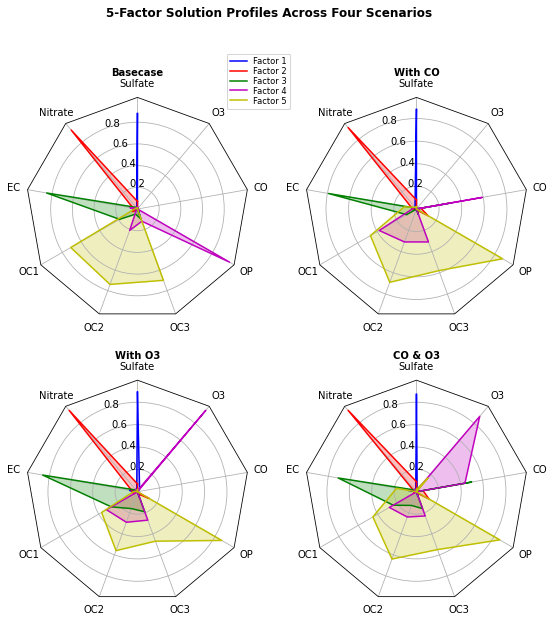

In [8]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

In [9]:
spider_chart_data = final_table_proportional.groupby(level=0).mean()
spider_chart_data = spider_chart_data[['iron_median', 'myelin_median', 'iron_iqr', 'myelin_iqr', 'volume_volume', 'thickness_median', 'thickness_iqr']]
spider_chart_data

,iron_median,myelin_median,iron_iqr,myelin_iqr,volume_volume,thickness_median,thickness_iqr
ROI,,,,,,,
3V,0.000,0.0000,0.0000,0.0000,0.5235,0.5480,0.0000
4V,0.000,0.0000,0.0000,0.0000,-0.2520,0.0000,-0.1810
AMG,0.600,0.0000,0.3030,0.1460,-0.2750,-0.1710,-0.1940
CL,0.000,0.0000,0.5830,0.0440,0.0000,0.0000,0.0000
GPe,0.142,-0.1790,0.5800,0.4150,0.0000,-0.1700,-0.1735
GPi,0.000,-0.0685,0.2410,0.4840,0.1200,0.0000,0.3420
LV,0.000,0.0000,0.0000,0.0000,0.7925,0.6495,0.0925
PAG,0.000,-0.0860,0.2720,0.1205,-0.0820,0.1100,0.1575
PPN,0.079,-0.0330,0.0985,0.0820,-0.0945,0.0385,0.0530


In [10]:
case_data

[[0.87, 0.01, 0.08, 0.0, 0.0, 0.04, 0.0, 0.0, 0.01],
 [0.09, 0.95, 0.02, 0.03, 0.0, 0.01, 0.13, 0.06, 0.0],
 [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.0, 0.5, 0.0],
 [0.01, 0.03, 0.0, 0.28, 0.24, 0.23, 0.0, 0.44, 0.88],
 [0.02, 0.0, 0.18, 0.45, 0.64, 0.55, 0.86, 0.0, 0.16]]

In [11]:
indx = spider_chart_data.index
indx = indx[~indx.isin(['3V', 'LV', '4V'])]
spider_chart_data = spider_chart_data.loc[indx]

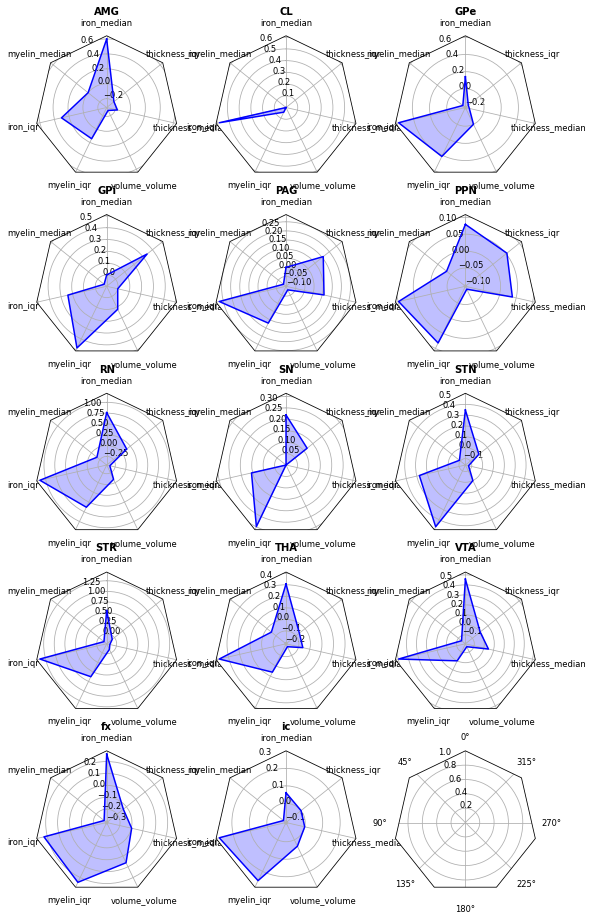

In [199]:
N = 7
theta = radar_factory(N, frame='polygon')

#data = example_data()
#spoke_labels = data.pop(0)

spoke_labels = spider_chart_data.columns

fig, axs = plt.subplots(figsize=(9, 15), nrows=5, ncols=3,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

#colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, spider_chart_data.iterrows()):
#     ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    ax.plot(theta, case_data.values, color='b')
    ax.fill(theta, case_data.values, facecolor='b', alpha=0.25)
#     for d, color in zip(case_data.values, colors):
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
#labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
# legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                           labelspacing=0.1, fontsize='small')

# fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
#          horizontalalignment='center', color='black', weight='bold',
#          size='large')

plt.show()

In [12]:
%load_ext rpy2.ipython

In [13]:
spider_chart_data.to_csv('./spider_chart_data.csv', sep='\t')

In [14]:
%%R -i spider_chart_data
#install.packages('fmsb', repos='https://cloud.r-project.org')
library('fmsb')
#spider_chart_data
max_vals = apply(spider_chart_data, 2, max)
spider_chart_data = rbind(max_vals, spider_chart_data)
spider_chart_data

par(mfrow=c(5,3))
i <- 1
for(roi in c('AMG', 'CL', 'GPe', 'GPi')) {
    i <- i+1
    radarchart(spider_chart_data[c(1,i),])    
}

R[write to console]: Error in library("fmsb") : there is no package called ‘fmsb’




Error in library("fmsb") : there is no package called ‘fmsb’


In [ ]:
spider_chart_data

## Correlation matrix

In [7]:
final_table_proportional2 = final_table_proportional.groupby(level=0).mean()
final_table_proportional2 = final_table_proportional2[['iron_median', 'iron_iqr', 'myelin_median', 'myelin_iqr', 'volume_volume', 'thickness_median', 'thickness_iqr']]
# final_table_proportional2 = final_table_proportional2.rename(index={'LVENT':'VENTL'}).sort_index()

In [9]:
final_table_proportional2.corr()

,iron_median,iron_iqr,myelin_median,myelin_iqr,volume_volume,thickness_median,thickness_iqr
iron_median,1.000000,0.679457,0.394441,0.501961,-0.221494,0.057631,-0.032454
iron_iqr,0.679457,1.000000,0.481018,0.673056,-0.397562,-0.026435,-0.054780
myelin_median,0.394441,0.481018,1.000000,0.514145,-0.427727,-0.100315,0.073913
myelin_iqr,0.501961,0.673056,0.514145,1.000000,-0.492859,-0.068416,0.299232
volume_volume,-0.221494,-0.397562,-0.427727,-0.492859,1.000000,0.791011,-0.029286
thickness_median,0.057631,-0.026435,-0.100315,-0.068416,0.791011,1.000000,-0.120886
thickness_iqr,-0.032454,-0.054780,0.073913,0.299232,-0.029286,-0.120886,1.000000


Text(24.0, 0.5, '')

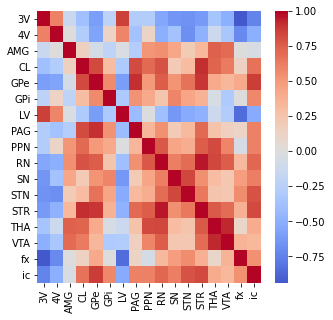

In [41]:
f, ax = plt.subplots(1,1, figsize=(5,5))
sns.heatmap(final_table_proportional2.T.corr(), cmap='coolwarm', center=0, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')

In [9]:
from matplotlib.font_manager import findfont, FontProperties


In [10]:
matplotlib.rcParams['font.family']
findfont(FontProperties(family=['sans-serif']))

'/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

Text(373.36363636363626, 0.5, '')

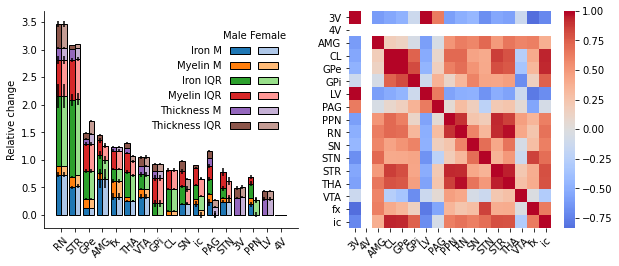

In [38]:
width = 0.4
widths = np.repeat(width, final_table_proportional.shape[0])
widths *= np.tile([-1,1], int(final_table_proportional.shape[0]/2))
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

f, ax = plt.subplots(1,2, figsize=(10,4))
#ax = [ax]

is_plotted = []
for i, dv in enumerate(['iron_median', 'myelin_median', 'iron_iqr', 'myelin_iqr', 'thickness_median', 'thickness_iqr']):
    errbar = msers[dv]
    if i == 0:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv, 
                  yerr=errbar)
    else:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv,
                  yerr=errbar,
                  bottom=final_table_proportional[is_plotted].sum(1))
        
    is_plotted.append(dv)

ax[0].set_xticks(ticks = np.arange(17))
ax[0].set_xticklabels(final_table_proportional.index.get_level_values(0).unique(), rotation=45, ha='center')
ax[0].set_ylabel('Relative change')

# custom legend
lwd = 1
custom_lines = [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(0,11,2)] + \
               [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(1,13,2)]

#
leg = ax[0].legend(custom_lines, ['Male', 'Iron M', 'Myelin M', 'Iron IQR', 'Myelin IQR', 'Thickness M', 'Thickness IQR',
                                  'Female', '', '' ,'' ,'' ,'', '', ''], ncol=2, markerfirst=False, 
                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white')
for i, vpack in enumerate(leg._legend_handle_box.get_children()):
    for j, hpack in enumerate(vpack.get_children()[:1]):
        if i == 0:
            hpack.get_children()[1].set_width(-5)
        else:
            hpack.get_children()[1].set_width(-16)            

sns.despine()


sns.heatmap(final_table_proportional2.T.corr(), cmap='coolwarm', center=0, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_xlabel('')
ax[1].set_ylabel('')

# f.savefig('../figures/figure3v2.pdf', bbox_inches='tight')

## Dendrogram

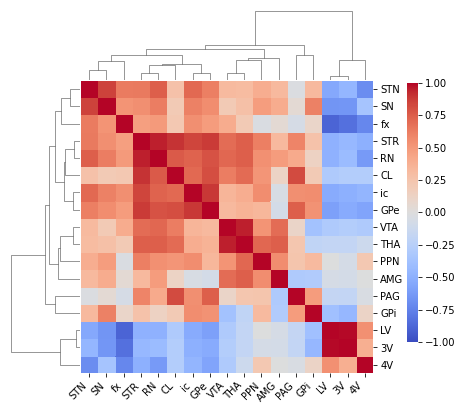

In [11]:
#f, ax = plt.subplots(1,1, figsize=(6,3.5))
# g = sns.clustermap(final_table_proportional2.loc[final_table_proportional2.index != '4V'].T.corr(), cmap='coolwarm', center=0, vmin=-1, 
#                    figsize=(6,6), xticklabels=1, cbar_pos=(0.95, 0.2, 0.025, 0.6))

#g = sns.clustermap(final_table_proportional2[['iron_median', 'iron_iqr', 'myelin_median', 'myelin_iqr', 'volume_volume']].T.corr(), cmap='coolwarm', center=0, vmin=-1, 
#                   figsize=(6,6), xticklabels=1, cbar_pos=(0.95, 0.2, 0.025, 0.6))

g = sns.clustermap(final_table_proportional2.T.corr(), cmap='coolwarm', center=0, vmin=-1, 
                   figsize=(6,6), xticklabels=1, cbar_pos=(0.95, 0.2, 0.025, 0.6))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='k', ha='right')
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

g.ax_heatmap.invert_xaxis()
g.ax_heatmap.invert_yaxis()
g.ax_row_dendrogram.invert_yaxis()
g.ax_col_dendrogram.invert_xaxis()

plt.gcf().savefig('../figures/figure5v5-massp2.pdf', bbox_inches='tight')

## Combined stacked bars & dendogram

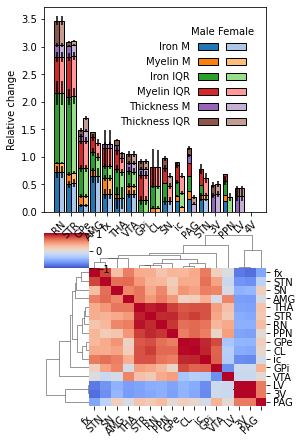

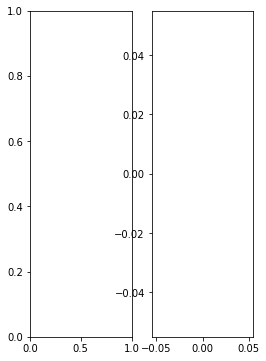

In [66]:
## SEs instead of MSER
width = 0.4
widths = np.repeat(width, final_table_proportional.shape[0])
widths *= np.tile([-1,1], int(final_table_proportional.shape[0]/2))
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)


#f, ax = plt.subplots(1,1, figsize=(6,3.5))
g = sns.clustermap(final_table_proportional2.loc[final_table_proportional2.index != '4V'].T.corr(), cmap='coolwarm', center=0, vmin=-1, 
                   figsize=(4,6), xticklabels=1)#, cbar_pos=(0.95, 0.2, 0.025, 0.6)) #, figsize=(6,6))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, color='k', ha='right')
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

g.ax_heatmap.invert_xaxis()
g.ax_heatmap.invert_yaxis()
g.ax_row_dendrogram.invert_yaxis()
g.ax_col_dendrogram.invert_xaxis()
g.gs.update(top=.45, bottom=0.05)


###
f, ax = plt.subplots(1,2, figsize=(4,6))
ax = [ax]

gs2 = matplotlib.gridspec.GridSpec(1,1, bottom=0.5)
# create axes within this new gridspec
ax = [g.fig.add_subplot(gs2[0])]

is_plotted = []
for i, dv in enumerate(['iron_median', 'myelin_median', 'iron_iqr', 'myelin_iqr', 'thickness_median', 'thickness_iqr']):
#     errbar = msers[dv]
    errbar = bootstrapped_SE[dv]
    if i == 0:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv, 
                  yerr=errbar)
    else:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv,
                  yerr=errbar,
                  bottom=final_table_proportional[is_plotted].sum(1))
        
    is_plotted.append(dv)

ax[0].set_xticks(ticks = np.arange(17))
ax[0].set_xticklabels(final_table_proportional.index.get_level_values(0).unique(), rotation=45, ha='center')
ax[0].set_ylabel('Relative change')

# custom legend
lwd = 1
custom_lines = [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(0,11,2)] + \
               [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(1,13,2)]

#
leg = ax[0].legend(custom_lines, ['Male', 'Iron M', 'Myelin M', 'Iron IQR', 'Myelin IQR', 'Thickness M', 'Thickness IQR',
                                  'Female', '', '' ,'' ,'' ,'', '', ''], ncol=2, markerfirst=False, 
                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False)
for i, vpack in enumerate(leg._legend_handle_box.get_children()):
    for j, hpack in enumerate(vpack.get_children()[:1]):
        if i == 0:
            hpack.get_children()[1].set_width(-5)
        else:
            hpack.get_children()[1].set_width(-16)

# sns.despine()
# f.savefig('../figures/figure4-v5.pdf', bbox_inches='tight')

In [53]:
g.show()

AttributeError: 'ClusterGrid' object has no attribute 'show'

## old stuff

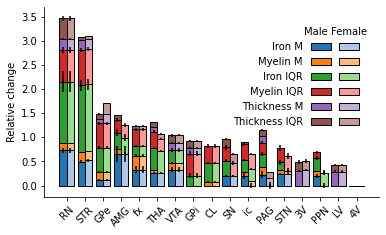

In [5]:
width = 0.4
widths = np.repeat(width, final_table_proportional.shape[0])
widths *= np.tile([-1,1], int(final_table_proportional.shape[0]/2))
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

f, ax = plt.subplots(1,1, figsize=(6,3.5))
ax = [ax]

is_plotted = []
for i, dv in enumerate(['iron_median', 'myelin_median', 'iron_iqr', 'myelin_iqr', 'thickness_median', 'thickness_iqr']):
    errbar = msers[dv]
    if i == 0:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv, 
                  yerr=errbar)
    else:
        ax[0].bar(x=final_table_proportional['index'].values, color=cmap(norm(i*2 + np.tile([0,1], 17))),
                  height=final_table_proportional[dv], width=widths, align='edge', edgecolor='k', label=dv,
                  yerr=errbar,
                  bottom=final_table_proportional[is_plotted].sum(1))
        
    is_plotted.append(dv)

ax[0].set_xticks(ticks = np.arange(17))
ax[0].set_xticklabels(final_table_proportional.index.get_level_values(0).unique(), rotation=45, ha='center')
ax[0].set_ylabel('Relative change')

# custom legend
lwd = 1
custom_lines = [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(0,11,2)] + \
               [plt.plot([],marker="", ls="")[0]] + [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=lwd, ec='k') for x in range(1,13,2)]

#
leg = ax[0].legend(custom_lines, ['Male', 'Iron M', 'Myelin M', 'Iron IQR', 'Myelin IQR', 'Thickness M', 'Thickness IQR',
                                  'Female', '', '' ,'' ,'' ,'', '', ''], ncol=2, markerfirst=False, 
                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False)
for i, vpack in enumerate(leg._legend_handle_box.get_children()):
    for j, hpack in enumerate(vpack.get_children()[:1]):
        if i == 0:
            hpack.get_children()[1].set_width(-5)
        else:
            hpack.get_children()[1].set_width(-16)

sns.despine()
f.savefig('../figures/figure4-v4.pdf', bbox_inches='tight')

In [53]:
timing = [
		1.345,
		1.3125,
		1.2775,
		1.245,
		1.21,
		1.1775,
		1.1425,
		1.11,
		1.075,
		1.0425,
		1.0075,
		0.975,
		0.9425,
		0.9075,
		0.875,
		0.84,
		0.8075,
		0.7725,
		0.74,
		0.705,
		0.6725,
		0.6375,
		0.605,
		0.57,
		0.5375,
		0.505,
		0.47,
		0.4375,
		0.4025,
		0.37,
		0.335,
		0.3025,
		0.2675,
		0.235,
		0.2,
		0.1675,
		0.1325,
		0.1,
		0.0675,
		0.0325,
		0,
		1.345,
		1.3125,
		1.2775,
		1.245,
		1.21,
		1.1775,
		1.1425,
		1.11,
		1.075,
		1.0425,
		1.0075,
		0.975,
		0.9425,
		0.9075,
		0.875,
		0.84,
		0.8075,
		0.7725,
		0.74,
		0.705,
		0.6725,
		0.6375,
		0.605,
		0.57,
		0.5375,
		0.505,
		0.47,
		0.4375,
		0.4025,
		0.37,
		0.335,
		0.3025,
		0.2675,
		0.235,
		0.2,
		0.1675,
		0.1325,
		0.1,
		0.0675,
		0.0325,
		0	]

In [56]:
np.where(np.array(timing)==0)[0]

array([40, 81])

In [58]:
np.diff(np.array(timing))

array([-0.0325, -0.035 , -0.0325, -0.035 , -0.0325, -0.035 , -0.0325,
       -0.035 , -0.0325, -0.035 , -0.0325, -0.0325, -0.035 , -0.0325,
       -0.035 , -0.0325, -0.035 , -0.0325, -0.035 , -0.0325, -0.035 ,
       -0.0325, -0.035 , -0.0325, -0.0325, -0.035 , -0.0325, -0.035 ,
       -0.0325, -0.035 , -0.0325, -0.035 , -0.0325, -0.035 , -0.0325,
       -0.035 , -0.0325, -0.0325, -0.035 , -0.0325,  1.345 , -0.0325,
       -0.035 , -0.0325, -0.035 , -0.0325, -0.035 , -0.0325, -0.035 ,
       -0.0325, -0.035 , -0.0325, -0.0325, -0.035 , -0.0325, -0.035 ,
       -0.0325, -0.035 , -0.0325, -0.035 , -0.0325, -0.035 , -0.0325,
       -0.035 , -0.0325, -0.0325, -0.035 , -0.0325, -0.035 , -0.0325,
       -0.035 , -0.0325, -0.035 , -0.0325, -0.035 , -0.0325, -0.035 ,
       -0.0325, -0.0325, -0.035 , -0.0325])

## New version of Figure 6

In [252]:
changes_proportional_f = pd.read_pickle('../data/interim_data/summary_table_qmri_proportional_f.pkl').reset_index().melt(id_vars='ROI', value_name='change_proportional')
changes_proportional_f['sex'] = 'f'
changes_proportional_m = pd.read_pickle('../data/interim_data/summary_table_qmri_proportional_m.pkl').reset_index().melt(id_vars='ROI', value_name='change_proportional')
changes_proportional_m['sex'] = 'm'
changes_proportional = pd.concat([changes_proportional_f, changes_proportional_m])
# changes_proportional

# bootstrapped CI
bootstrapped_CI = pd.read_pickle('../data/bootstraps/all_bootstrapped_data_n=10000.pkl')
bootstrapped_CI['CI_lower_f'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['CI'][0])
bootstrapped_CI['CI_upper_f'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['CI'][1])
bootstrapped_CI['CI_lower_m'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_m']['CI'][0])
bootstrapped_CI['CI_upper_m'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_m']['CI'][1])
bootstrapped_CI['median_f'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['median'])
bootstrapped_CI['median_m'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['median'])
bootstrapped_CI['SE_f'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['SE'])
bootstrapped_CI['SE_m'] = bootstrapped_CI['bootstrap_results'].apply(lambda x: x['relative_mean_change_f']['SE'])
# bootstrapped_CI

In [283]:
bootstrapped_CI.loc[(bootstrapped_CI.ROI=='THA') & (bootstrapped_CI.qMRI == 'iron')]

,ROI,qMRI,Statistic,ivs,model,result,BIC,rsquared,is_winner_BIC,ivs_2,new_winning_model_3,bootstrap_results,CI_lower_f,CI_upper_f,CI_lower_m,CI_upper_m,median_f,median_m,SE_f,SE_m
5010,THA,iron,median,Age + Age2,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,206.439790,0.181318,True,Age + Age2,False,{'absolute_mean_change': {'CI': [-2.1531340373...,-0.432477,0.436006,-0.432477,0.436006,0.286183,0.286183,0.251547,0.251547
5034,THA,iron,iqr,Age + Age2,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,196.140018,0.402777,True,Age + Age2,False,{'absolute_mean_change': {'CI': [1.10536155251...,0.292203,0.535860,0.292203,0.535860,0.393158,0.393158,0.062297,0.062297


In [282]:
changes_proportional.loc[(changes_proportional.ROI=='THA') & (changes_proportional.qMRI == 'iron')]

,ROI,qMRI,Statistic,change_proportional,sex
13,THA,iron,iqr,0.382,f
30,THA,iron,median,0.307,f
13,THA,iron,iqr,0.382,m
30,THA,iron,median,0.307,m


In [257]:
medians

ROI
AMG   -0.275
AMG   -0.275
Name: change_proportional, dtype: float64

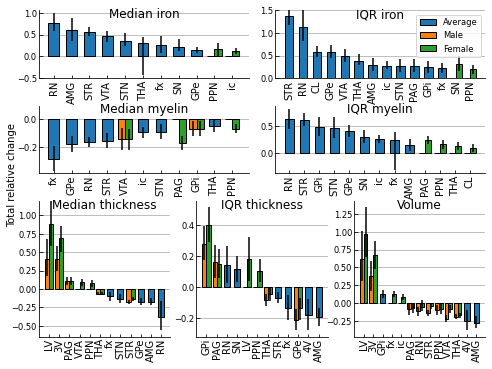

In [284]:
import matplotlib.gridspec as gridspec
rcPars_to_update = {'figure.titlesize': 'medium',
                    'font.size': 10,
                    'ytick.labelsize': 'small',
                    'ytick.labelsize': 'small',
                    }
matplotlib.rcParams.update(**rcPars_to_update)

widths = [0.6, 0.4]
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

#f, ax = plt.subplots(4,2, figsize=(8,8))
f = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(nrows=3, ncols=6, figure=f, height_ratios=(2,2,4), hspace=.3, wspace=.5)
#gs0 = gridspec.GridSpecFromSubplotSpec(2,2,gs[0,0], width_ratios=[3,4])  #myelin,iron
#gs1 = gridspec.GridSpecFromSubplotSpec(1,3,gs[1,0])  #thickness, volume

all_axes = []
for i, measure in enumerate(['iron', 'myelin', 'thickness', 'volume']):
    for ii, statistic in enumerate(['median', 'iqr']):
        if measure == 'volume':
            statistic = 'volume'
        dv_colname = measure+'_'+statistic
        if measure == 'volume' and ii == 1:
            continue
        
        ##
        if measure in ['iron', 'myelin']:
            col = slice(0,3) if statistic == 'median' else slice(3,6)
        else:
            col = slice(0,2) if statistic == 'median' else slice(2,4) if statistic == 'iqr' else slice(4,6)
        i = np.min([i,2])
#         col = slice(ii*2, ii*2+2) if measure in ['thickness', 'volume'] else slice(0,3) if measure == 'iron' else slice(3,6)
        
        this_ax = f.add_subplot(gs[i,col])
        this_ax.grid(which='both', axis='y')
        this_ax.set_axisbelow(True)
        
        tmp = changes_proportional.loc[(changes_proportional.qMRI==measure) & (changes_proportional.Statistic == statistic)]
        ROI_order = tmp.groupby(['ROI', 'qMRI', 'Statistic']).mean().reset_index().sort_values(by='change_proportional', ascending=(measure == 'myelin' and statistic == 'median')).ROI.values

        if measure in ['iron', 'myelin']:
            ROI_order = np.array([x for x in ROI_order if not x in ['LV', '3V', '4V']])  # don't plot ventricles here

        # to plot
        tmp = tmp.set_index('ROI').loc[ROI_order]

        # SI
        rois_without_change = tmp.groupby(level=0)['change_proportional'].mean()==0 #tmp.groupby(level=0).mean()==0
        tmp = tmp.loc[rois_without_change[~rois_without_change].index]  # remove rois that are stable
        rois_without_change = rois_without_change[rois_without_change].index
        ROI_order = np.array([x for x in ROI_order if not x in rois_without_change])      # remove rois that are stable

        # error bars
        errbars = bootstrapped_CI.loc[(bootstrapped_CI.qMRI==measure) & (bootstrapped_CI.Statistic == statistic), 
                                      ['ROI', 'qMRI', 'Statistic', 'CI_lower_f', 'CI_upper_f', 'CI_lower_m', 'CI_upper_m']]
        errbars.set_index('ROI').loc[ROI_order]

        # locations, widths of bars
        widths_ = widths[:ROI_order.shape[0]*2]
        x = np.repeat(np.arange(ROI_order.shape[0]), 2)
        
        # loop
        positions = []
        pos = -0.2 - widths[0]
        for iii, roi in enumerate(ROI_order):
            medians = tmp.loc[roi, 'change_proportional']
            SEs = errbars.loc[errbars.ROI==roi, ['CI_lower_f', 'CI_upper_f', 'CI_lower_m', 'CI_upper_m']].values[0].reshape(2,2, order='F')
            SEs = SEs - medians.values  # in pyplot.bar, yerr is not absolute but relative to median
            SEs = np.abs(SEs)
            if medians.unique().shape[0] == 1:  # m and f are the same
#                pos += 0.2 + widths[0]
                this_ax.bar(x=iii, 
                            height=medians.values[0], 
                            yerr=SEs[:,0].reshape((2,1)),
                            color=cmap(norm(0)), edgecolor='k', width=widths[0])
            else:
#                pos += 0.2 + widths[1]
                this_ax.bar(x=iii + np.array([-.5*widths[1], .5*widths[1]]), #pos + np.array([-.5*widths[1], .5*widths[1]]), 
                             height=medians, 
                             yerr=SEs,
                             color=[cmap(norm(2)), cmap(norm(4))], edgecolor='k', width=widths[1])
        
#             positions.append(pos)

        this_ax.set_xticks(ticks = np.arange(len(x)/2))
        this_ax.set_xticklabels(ROI_order, rotation=90, ha='center')

#         if measure == 'myelin' and statistic == 'median':
#             xy_loc = (0.05, 0.05)
#             va='bottom'
#             ha='left'
#         else:
#             xy_loc = (0.95, 0.95)
#             va='top'
#             ha='right'
#         if not (measure == 'iron' and statistic == 'iqr'):
#             this_ax.annotate(text='Stable: {}'.format(', '.join(rois_without_change)), 
#                               xy=xy_loc, xycoords='axes fraction',
#                               ha=ha, va=va,bbox=dict(boxstyle="round", fc="w", edgecolor='lightgray'))
#        ax[i,ii].text(0,0,s='Stable: {}'.format(', '.join(rois_without_change)))
#        ax[i,ii].set_ylabel(dv_colname)

        all_axes.append(this_ax)
#    is_plotted.append(dv)

custom_lines = [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=1, ec='k') for x in [0,2,4]]

#
leg = all_axes[1].legend(custom_lines, ['Average', 'Male', 'Female'], prop={'size': 'small'}) #, ncol=1, markerfirst=False, 
#                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False,
#                   bbox_to_anchor=(.55, .6, 0.5, 0.5))

for ax_ in all_axes:
    ax_.tick_params(direction='in', pad=2)

all_axes[0].set_title('Median iron', y=.8)
all_axes[1].set_title('IQR iron', y=.8)
all_axes[2].set_title('Median myelin', y=.8)
all_axes[3].set_title('IQR myelin', y=.8)
all_axes[4].set_title('Median thickness', y=.9)
all_axes[5].set_title('IQR thickness', y=.9)
all_axes[6].set_title('Volume', y=.9)

all_axes[1].set_ylim([all_axes[1].get_ylim()[0], 1.5])  # IQR iron: Prevent overlap
all_axes[2].set_ylim([all_axes[2].get_ylim()[0], 0.1])  # median myelin: Make room for title
all_axes[4].set_ylim([all_axes[4].get_ylim()[0], 1.2])  # median thickness: avoid ugly overlap with gridline at 1

f.supylabel('Total relative change', x=0.07)

sns.despine()
f.savefig('./figure6newtest4.pdf', bbox_inches='tight')

In [ ]:
import matplotlib.gridspec as gridspec
rcPars_to_update = {'figure.titlesize': 'medium',
                    'font.size': 10,
                    'ytick.labelsize': 'small',
                    'ytick.labelsize': 'small',
                    }
matplotlib.rcParams.update(**rcPars_to_update)

widths = [0.6, 0.4]
cmap = plt.get_cmap('tab20')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

#f, ax = plt.subplots(4,2, figsize=(8,8))
f = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(nrows=3, ncols=6, figure=f, height_ratios=(2,2,4), hspace=.3, wspace=.5)
#gs0 = gridspec.GridSpecFromSubplotSpec(2,2,gs[0,0], width_ratios=[3,4])  #myelin,iron
#gs1 = gridspec.GridSpecFromSubplotSpec(1,3,gs[1,0])  #thickness, volume

all_axes = []
for i, measure in enumerate(['iron', 'myelin', 'thickness', 'volume']):
    for ii, statistic in enumerate(['median', 'iqr']):
        if measure == 'volume':
            statistic = 'volume'
        dv_colname = measure+'_'+statistic
        if measure == 'volume' and ii == 1:
            continue
        
        ##
        if measure in ['iron', 'myelin']:
            col = slice(0,3) if statistic == 'median' else slice(3,6)
        else:
            col = slice(0,2) if statistic == 'median' else slice(2,4) if statistic == 'iqr' else slice(4,6)
        i = np.min([i,2])
#         col = slice(ii*2, ii*2+2) if measure in ['thickness', 'volume'] else slice(0,3) if measure == 'iron' else slice(3,6)
        
        this_ax = f.add_subplot(gs[i,col])
        this_ax.grid(which='both', axis='y')
        this_ax.set_axisbelow(True)
        
        # get data
        tmp = changes_proportional.loc[(changes_proportional.qMRI==measure & changes_proportional.Statistic == statistic)]
        # sort
#        tmp = changes_proportional[dv_colname]
        indx = tmp.groupby(level=1).mean().sort_values(ascending=(measure == 'myelin' and statistic == 'median')).index  # sorting # tmp.groupby(level=0).mean().sort_values(ascending=(measure == 'myelin' and statistic == 'median')).index  # sorting
        if measure in ['iron', 'myelin']:
            indx = np.array([x for x in indx if not x in ['LV', '3V', '4V']])  # don't plot ventricles here
        tmp = tmp.loc[indx]  # remove ventricles if necessary
        
        rois_without_change = tmp.groupby(level=0).mean()==0
        tmp = tmp.loc[rois_without_change[~rois_without_change].index]  # remove rois that are stable
        rois_without_change = rois_without_change[rois_without_change].index
        indx = np.array([x for x in indx if not x in rois_without_change])      # remove rois that are stable

#        if measure == 'myelin' and statistic == 'median'
        
        errbars = bootstrapped_SE.reindex(indx, level=0)[dv_colname]
        medians = final_table_proportional.reindex(indx, level=0)[dv_colname]
        widths_ = widths[:indx.shape[0]*2]
        x = np.repeat(np.arange(indx.shape[0]), 2)
        
       
        # loop
        positions = []
        pos = -0.2 - widths[0]
        for iii, roi in enumerate(indx):
            values = final_table_proportional.loc[roi, dv_colname]
            if values.unique().shape[0] == 1:  # m and f are the same
#                pos += 0.2 + widths[0]
                this_ax.bar(x=iii, 
                             height=values[0], 
                             yerr=bootstrapped_SE.loc[roi, dv_colname][0],
                             color=cmap(norm(0)), edgecolor='k', width=widths[0])
            else:
#                pos += 0.2 + widths[1]
                this_ax.bar(x=iii + np.array([-.5*widths[1], .5*widths[1]]), #pos + np.array([-.5*widths[1], .5*widths[1]]), 
                             height=values, 
                             yerr=bootstrapped_SE.loc[roi, dv_colname],
                             color=[cmap(norm(2)), cmap(norm(4))], edgecolor='k', width=widths[1])
        
#             positions.append(pos)

        this_ax.set_xticks(ticks = np.arange(len(x)/2))
        this_ax.set_xticklabels(indx, rotation=90, ha='center')

#         if measure == 'myelin' and statistic == 'median':
#             xy_loc = (0.05, 0.05)
#             va='bottom'
#             ha='left'
#         else:
#             xy_loc = (0.95, 0.95)
#             va='top'
#             ha='right'
#         if not (measure == 'iron' and statistic == 'iqr'):
#             this_ax.annotate(text='Stable: {}'.format(', '.join(rois_without_change)), 
#                               xy=xy_loc, xycoords='axes fraction',
#                               ha=ha, va=va,bbox=dict(boxstyle="round", fc="w", edgecolor='lightgray'))
#        ax[i,ii].text(0,0,s='Stable: {}'.format(', '.join(rois_without_change)))
#        ax[i,ii].set_ylabel(dv_colname)

        all_axes.append(this_ax)
#    is_plotted.append(dv)

custom_lines = [plt.Rectangle((0,0), 0, 0, fc=cmap(norm(x)), lw=1, ec='k') for x in [0,2,4]]

#
leg = all_axes[1].legend(custom_lines, ['Average', 'Male', 'Female'], prop={'size': 'small'}) #, ncol=1, markerfirst=False, 
#                   columnspacing=0, borderaxespad=1, borderpad=1, loc=1, edgecolor='white', frameon=False,
#                   bbox_to_anchor=(.55, .6, 0.5, 0.5))

for ax_ in all_axes:
    ax_.tick_params(direction='in', pad=2)

all_axes[0].set_title('Median iron', y=.8)
all_axes[1].set_title('IQR iron', y=.8)
all_axes[2].set_title('Median myelin', y=.8)
all_axes[3].set_title('IQR myelin', y=.8)
all_axes[4].set_title('Median thickness', y=.9)
all_axes[5].set_title('IQR thickness', y=.9)
all_axes[6].set_title('Volume', y=.9)

all_axes[1].set_ylim([all_axes[1].get_ylim()[0], 1.5])  # IQR iron: Prevent overlap
all_axes[2].set_ylim([all_axes[2].get_ylim()[0], 0.1])  # median myelin: Make room for title
all_axes[4].set_ylim([all_axes[4].get_ylim()[0], 1.2])  # median thickness: avoid ugly overlap with gridline at 1

f.supylabel('Total relative change', x=0.07)

sns.despine()
# f.savefig('./figure6newtest3.pdf', bbox_inches='tight')